In [ ]:
!pip install tensorflow


In [ ]:
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
from PIL import Image
from glob import glob
from google.colab import drive

In [ ]:
drive.mount('/content/drive')
data_path = "/content/drive/MyDrive/DIV2K_data/DIV2K_valid_HR"
image_paths = sorted(glob(os.path.join(data_path, "*.png")))

print(f"Total images found: {len(image_paths)}")

Mounted at /content/drive
Total images found: 100


Final gray shape: (396, 600, 1)
Final pred shape: (396, 600, 1)
PSNR:  29.58506


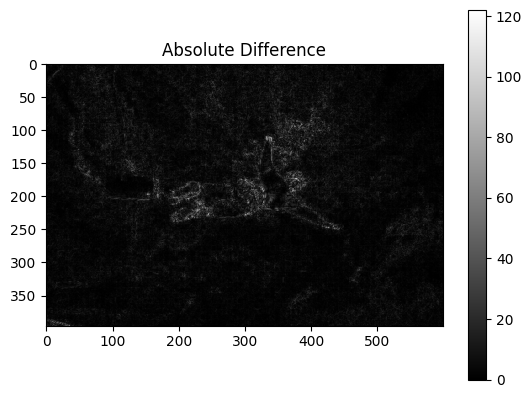

In [ ]:
def center_crop(img, target_height, target_width):
    h, w = img.shape[:2]
    top = (h - target_height) // 2
    left = (w - target_width) // 2
    return img[top:top+target_height, left:left+target_width]

gray = tf.convert_to_tensor(gray)
pred = tf.convert_to_tensor(pred)

gray = tf.squeeze(gray)
pred = tf.squeeze(pred)

if len(gray.shape) == 2:
  gray = tf.expand_dims(gray, axis = -1)
if len(pred.shape) == 2:
  pred = tf.expand_dims(pred, axis = -1)

if gray.shape != pred.shape:
    target_height = min(gray.shape[0], pred.shape[0])
    target_width = min(gray.shape[1], pred.shape[1])
    gray = center_crop(gray, target_height, target_width)
    pred = center_crop(pred, target_height, target_width)

print("Final gray shape:", gray.shape)
print("Final pred shape:", pred.shape)

gray = tf.cast(gray, tf.float32)
pred = tf.cast(pred, tf.float32)

if tf.reduce_max(gray) <= 1.0:
    gray *= 255.0
if tf.reduce_max(pred) <= 1.0:
    pred *= 255.0

psnr_value =tf.image.psnr(gray, pred, max_val = 255.0)
print(f"PSNR: ", psnr_value.numpy())

diff = tf.abs(gray - pred)
plt.imshow(tf.squeeze(diff), cmap='gray')
plt.title("Absolute Difference")
plt.colorbar()
plt.show()

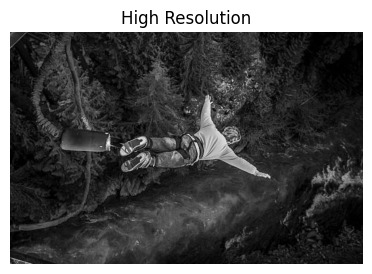

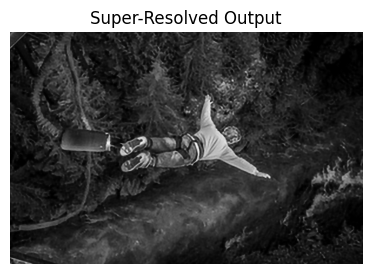

In [ ]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.imshow(gray, cmap='gray')
plt.title("High Resolution")
plt.axis('off')

pred = np.squeeze(pred)
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.imshow(pred, cmap = 'gray')
plt.title("Super-Resolved Output")
plt.axis('off')
plt.show()

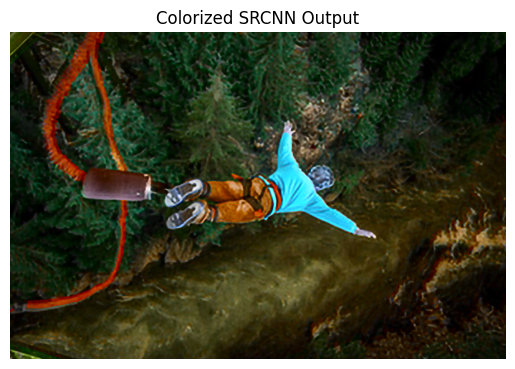

In [ ]:
low_res_rgb = cv2.resize(img, (pred.shape[1], pred.shape[0]), interpolation=cv2.INTER_CUBIC)

low_res_ycrcb = cv2.cvtColor(low_res_rgb, cv2.COLOR_RGB2YCrCb)
_, cr, cb = cv2.split(low_res_ycrcb)

cr_up = cv2.resize(cr, (pred.shape[1], pred.shape[0]), interpolation=cv2.INTER_CUBIC)
cb_up = cv2.resize(cb, (pred.shape[1], pred.shape[0]), interpolation=cv2.INTER_CUBIC)

if tf.reduce_max(pred) <= 1.0:
    pred = pred * 255.0
pred_uint8 = np.clip(pred, 0, 255).astype(np.uint8)

ycrcb_merged = cv2.merge([pred_uint8, cr_up, cb_up])
final_rgb = cv2.cvtColor(ycrcb_merged, cv2.COLOR_YCrCb2RGB)

plt.imshow(final_rgb)
plt.title("Colorized SRCNN Output")
plt.axis('off')
plt.show()

In [ ]:
def shift_and_psnr(pred, gray):
    shifts = [-1, 0, 1]
    for dx in shifts:
        for dy in shifts:
            shifted = tf.roll(pred, shift=[dy, dx], axis=[0, 1])
            value = tf.image.psnr(gray, shifted, max_val=255.0)
            print(f"Shift x={dx}, y={dy} -> PSNR: {value.numpy():.2f}")

shift_and_psnr(pred, gray)

Shift x=-1, y=-1 -> PSNR: 24.29
Shift x=-1, y=0 -> PSNR: 25.90
Shift x=-1, y=1 -> PSNR: 24.17
Shift x=0, y=-1 -> PSNR: 25.87
Shift x=0, y=0 -> PSNR: 29.59
Shift x=0, y=1 -> PSNR: 25.85
Shift x=1, y=-1 -> PSNR: 24.17
Shift x=1, y=0 -> PSNR: 25.90
Shift x=1, y=1 -> PSNR: 24.31


In [ ]:
from google.colab import files
files.download('super_resolved_output.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Visualize Super-Resolved Output

In [ ]:
plt.figure(figsize=(10, 8))
plt.imshow(final_rgb)
plt.title("Super-Resolved Color Image")
plt.axis('off')
plt.show()

### Save Super-Resolved Output

In [ ]:
# Convert the final_rgb image to BGR format for saving with OpenCV
final_bgr = cv2.cvtColor(final_rgb, cv2.COLOR_RGB2BGR)

# Save the image
cv2.imwrite("super_resolved_output.png", final_bgr)

True

### Finish task
The super-resolution model has been applied to the input image, the output has been visualized, and the colorized super-resolved image has been saved.